# Quickstart

Based on the tutorial: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html

This notebook provides a quick introduction to PyTorch, covering the basics of working with data, defining models, training, and evaluating them. It uses the FashionMNIST dataset for demonstration purposes.

The dataset is loaded using `torchvision.datasets.FashionMNIST` and transformed to tensors using `torchvision.transforms.ToTensor`. The data is then split into training and test sets, which are loaded using `DataLoader` with a specified batch size.

A simple neural network model is defined using `torch.nn.Module`, consisting of two fully connected layers with ReLU activations. The model is trained using the SGD optimizer and cross-entropy loss function. The training loop iterates over the dataset for a specified number of epochs, updating the model parameters to minimize the loss.

After training, the model is evaluated on the test set to measure its accuracy. The evaluation loop computes the accuracy by comparing the model's predictions with the true labels.

Additionally, the notebook includes code to save the trained model's state dictionary to a file and load it back for inference. This allows for the model to be reused without retraining.

The notebook concludes with a section on visualizing the model's predictions on a few test images, providing a qualitative assessment of the model's performance.

Most of the boilerplate for the training is handled by the manager class. This includes printing metrics during training and periodically saving the model, allowing training to be resumed from the last checkpoint.

The executor `GeneralBatchExecutor` is the default and simplest executor that expects a tensor as input, runs the model with that input, and returns the output. The evaluator `MaxProbEvaluator` receives the output from the executor, which is expected to be a tensor with probabilities for different categories. It returns an object with a `prediction` attribute that is a tuple containing the probability and the label with the highest probability. When calling `manager.evaluate(input)`, it runs the evaluator, which processes the input to give an output, and then processes the output of the model to get the category with the highest probability.

A different executor can be used instead of the `GeneralBatchExecutor` passed to `MaxProbEvaluator`, which may be convenient for handling different kinds of input (such as a raw image or image path that needs to be converted into a tensor, which can be useful during evaluation instead of receiving a tensor directly). Additionally, a custom evaluator can perform all these tasks without the need for an executor.

A custom metrics class was used to calculate and display metrics related to losses, accuracy, and training times, which were then saved to a PDF file (`REPORT_PATH`). You can find implementation examples of various metrics classes in [lib/metrics.py](../lib/metrics.py).

### Working with data

In [1]:
NAME = 'quickstart'
SAVE_PATH = f'data/test/train/{NAME}-checkpoint.pth'
REPORT_PATH = f'data/test/train/{NAME}-report.pdf'

In [2]:
import sys
if "../" not in sys.path:
  sys.path.append("../")

In [3]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [5]:
# Download training data from open datasets.
full_training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [6]:
# divide the training data into training and validation data (80/20)
from torch.utils.data import Subset
data_list = [d for d in full_training_data]
amount = len(data_list)
training_data = Subset(full_training_data, list(range(int(amount*0.8))))
validation_data = Subset(full_training_data, list(range(int(amount*0.8), amount)))

In [7]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f"[train] Shape of X [N, C, H, W]: {X.shape}")
    print(f"[train] Shape of y: {y.shape} {y.dtype}")
    break

for X, y in test_dataloader:
    print(f"[test ] Shape of X [N, C, H, W]: {X.shape}")
    print(f"[test ] Shape of y: {y.shape} {y.dtype}")
    break

[train] Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
[train] Shape of y: torch.Size([64]) torch.int64
[test ] Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
[test ] Shape of y: torch.Size([64]) torch.int64


### Creating Models

In [8]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Creating the manager

In [9]:
from auto_mind import supervised
from auto_mind.supervised.handlers import GeneralBatchExecutor, MaxProbEvaluator, GeneralBatchAccuracyCalculator
from src.lib.metrics import MainMetrics

manager = supervised.Manager(
    data_params=supervised.ManagerDataParams(
        train_dataloader=train_dataloader,
        validation_dataloader=validation_dataloader,
        test_dataloader=test_dataloader,
    ),
    model_params=supervised.ManagerModelParams(
        model=model,
        criterion=nn.CrossEntropyLoss(),
        executor=GeneralBatchExecutor(),
        use_best=False,
    ),
    optimizer_params=supervised.ManagerOptimizerParams(
        optimizer=torch.optim.SGD(model.parameters(), lr=1e-3),
        scheduler=None,
        train_early_stopper=None,
        test_early_stopper=None,
    ),
    metrics_params=supervised.ManagerMetricsParams(
        evaluator=MaxProbEvaluator(executor=GeneralBatchExecutor()),
        accuracy_calculator=GeneralBatchAccuracyCalculator(),
        metrics_calculator=MainMetrics(name=NAME).as_file_plotter(REPORT_PATH),
        batch_interval=False,
        default_interval=1,
    ),
    config=supervised.ManagerConfig(
        save_path=SAVE_PATH,
        random_seed=0,
        train_hook=None,
    ),
)

### Training and Metrics

Starting training for 25 epochs...
[end of epoch  1 (  4.0%)] [time:    0m 8.43s (eta:   3m 22.38s)] [val_accuracy:  47.5%, train_accuracy:  30.5%] [val_loss: 0.0344, train_loss: 0.0352]
[end of epoch  2 (  8.0%)] [time:   0m 16.58s (eta:   3m 10.70s)] [val_accuracy:  54.4%, train_accuracy:  51.6%] [val_loss: 0.0318, train_loss: 0.0332]
[end of epoch  3 ( 12.0%)] [time:   0m 24.24s (eta:   2m 57.79s)] [val_accuracy:  58.9%, train_accuracy:  56.1%] [val_loss: 0.0276, train_loss: 0.0298]
[end of epoch  4 ( 16.0%)] [time:   0m 32.49s (eta:   2m 50.60s)] [val_accuracy:  62.5%, train_accuracy:  60.1%] [val_loss: 0.0231, train_loss: 0.0253]
[end of epoch  5 ( 20.0%)] [time:   0m 40.92s (eta:   2m 43.66s)] [val_accuracy:  64.5%, train_accuracy:  62.8%] [val_loss: 0.0198, train_loss: 0.0214]
[end of epoch  6 ( 24.0%)] [time:   0m 49.15s (eta:   2m 35.65s)] [val_accuracy:  66.1%, train_accuracy:  64.6%] [val_loss: 0.0175, train_loss: 0.0187]
[end of epoch  7 ( 28.0%)] [time:   0m 58.85s (eta:  

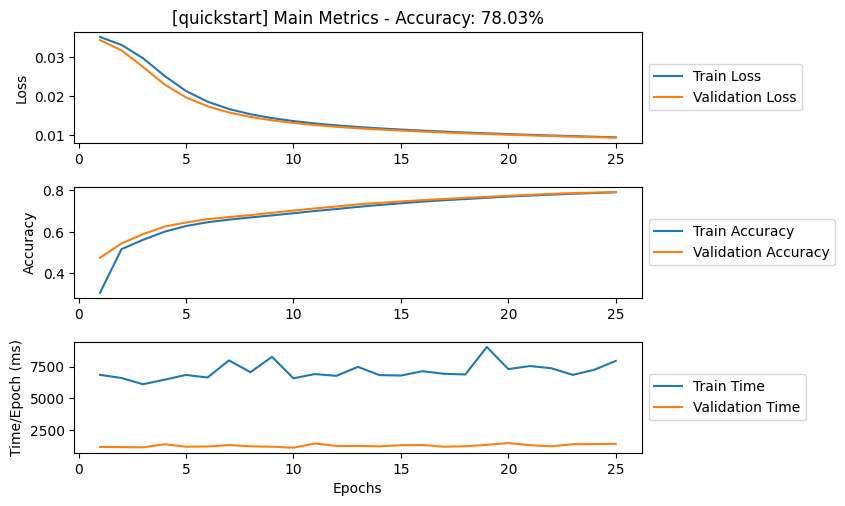

In [10]:
manager.train(epochs=25)

### Making Predictions

In [11]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

x, y = test_data[0][0], test_data[0][1]
result = manager.evaluate(x)
confidence, label = result.prediction
predicted, actual = classes[label], classes[y]
print(f"Predicted: '{predicted}', Actual: '{actual}'")

Predicted: 'Ankle boot', Actual: 'Ankle boot'
